In [2]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import random

In [3]:
SEED = 1
# Use GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [4]:
imagenette_transforms = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ]
)

In [5]:
data_train = torchvision.datasets.Imagenette(root='./datasets/imagenette', split='train', download=False, transform=imagenette_transforms)
data_val = torchvision.datasets.Imagenette(root='./datasets/imagenette', split='val', download=False, transform=imagenette_transforms)

In [6]:
class ImagenetteDataset(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):
        self.transforms = transform
        self.data = data

    def __getitem__(self,index):
        image,label = self.data[index]
        if self.transforms != None:
            image = self.transforms(image)

        label = 1 if label==3 else 0

        return image,label

    def __len__(self):
        return len(self.data)

In [7]:
data_train_chainsaw = ImagenetteDataset(data_train)
data_val_chainsaw = ImagenetteDataset(data_val)

In [8]:
train_loader = torch.utils.data.DataLoader(data_train_chainsaw, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(data_val_chainsaw, batch_size=64, shuffle=False)

In [9]:
for b,c in train_loader:
    for d,e in zip(b,c):
        transform = transforms.ToPILImage()
        img = transform(d)
        # img.show()
        print(e)
    break

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [10]:
class Resnet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet18(weights='DEFAULT')
        self.backbone.fc = nn.Identity()
        self.backbone.to(device)
        self.head = nn.Linear(512, num_classes)
        self.head.to(device)

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [11]:
# model = Resnet18(num_classes=2)
model = models.resnet18()
lr = 0.008
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if torch.cuda.is_available():
    model.cuda()

In [12]:
def train(model,data_loader,criterion,optimizer,attack=False):

    running_loss = 0.
    running_steps = 0
    n_correct = 0
    n_total = 0

    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for batch_idx, (inputs, targets) in enumerate(train_tqdm):
            model.train() # add a call before calling train function
            model.to(device)
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_steps += 1

            _, pred = torch.max(outputs, 1)
            n_correct += (pred==targets).sum().item()
            n_total += len(targets)
    
    average_train_loss = running_loss / running_steps
    accuracy = n_correct / n_total * 100.

    return average_train_loss, accuracy

In [13]:
@torch.no_grad()
def test(model,data_loader,criterion,optimizer,attack=False):
    model.eval()

    running_loss = 0.
    running_steps = 0
    n_correct = 0
    n_total = 0

    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            running_loss += loss.item()
            running_steps += 1

            _, pred = torch.max(outputs, 1)
            n_correct += (pred==targets).sum().item()
            n_total += len(targets)
    
    average_test_loss = running_loss / running_steps
    accuracy = n_correct / n_total * 100.0

    return average_test_loss, accuracy

In [14]:
for i in range(2):
    train_avg_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    if (i+1)%10 == 0:
        val_avg_loss, val_accuracy = test(model, val_loader, criterion, optimizer)
        print('Epoch: {:3d}, Train Average Loss: {:.2f}, Train Accuracy: {:.1f}%, Validation Average Loss: {:.2f}, Validation Accuracy: {:.1f}%'\
              .format(i+1, train_avg_loss, train_accuracy, val_avg_loss, val_accuracy))

   train: 100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


In [15]:
val_avg_loss, val_accuracy = test(model, val_loader, criterion, optimizer)
print('Validation Average Loss: {:.2f}, Validation Accuracy: {:.1f}%'\
              .format(val_avg_loss, val_accuracy))

   test: 100%|██████████| 62/62 [00:23<00:00,  2.59it/s]

Validation Average Loss: 0.36, Validation Accuracy: 90.2%


In [35]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

model._modules.get('layer4').register_forward_hook(hook_feature)

params = list(model.parameters())
weight = np.squeeze(params[-2].data.cpu().numpy())
print(params[-2].shape)
print(weight.shape)

torch.Size([1000, 512])
(1000, 512)


In [30]:
sample_img = torch.autograd.Variable(data_val_chainsaw[50][0].unsqueeze(0))
sample_img = sample_img.to(device)
model.to(device)
logit = model(sample_img)


In [34]:
_, nc, h, w = features_blobs[0].shape
r = np.reshape(features_blobs[0], (nc, h*w))
r.shape

(512, 49)

In [43]:
import cv2
c = weight[0] @ r
c = c.reshape((h, w))
c = c - np.min(c)
c = c / np.max(c)
c_i = np.uint8(255 * c)
c_i = cv2.resize(c_i, (224, 224))
c_i

array([[30, 30, 30, ..., 24, 24, 24],
       [30, 30, 30, ..., 24, 24, 24],
       [30, 30, 30, ..., 24, 24, 24],
       ...,
       [24, 24, 24, ..., 82, 82, 82],
       [24, 24, 24, ..., 82, 82, 82],
       [24, 24, 24, ..., 82, 82, 82]], dtype=uint8)

[[[165  99 102]
  [163  95  97]
  [181 111 112]
  ...
  [193 127 127]
  [193 126 126]
  [193 127 127]]

 [[167  99 103]
  [160  92  94]
  [175 105 106]
  ...
  [192 127 127]
  [193 127 127]
  [191 125 126]]

 [[191 120 121]
  [190 118 119]
  [188 116 115]
  ...
  [186 123 123]
  [188 124 124]
  [177 113 114]]

 ...

 [[159  82  72]
  [153  77  67]
  [152  75  66]
  ...
  [137 111  45]
  [139 111  44]
  [154 126  58]]

 [[158  83  73]
  [155  79  69]
  [154  78  68]
  ...
  [150 124  57]
  [147 124  56]
  [154 130  62]]

 [[156  81  71]
  [154  80  69]
  [151  76  66]
  ...
  [155 128  61]
  [157 128  62]
  [154 125  59]]]


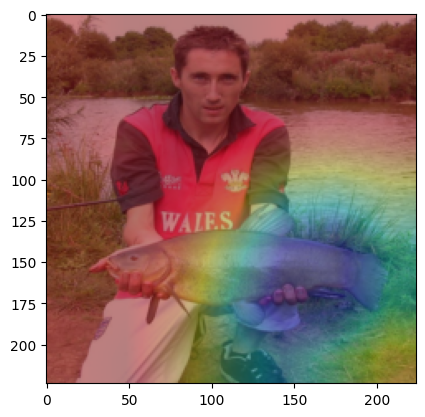

In [66]:
img = np.uint8(255 * data_val_chainsaw[50][0].permute(1, 2, 0).numpy())
heatmap = cv2.applyColorMap(c_i, cv2.COLORMAP_JET)
result = np.uint8(0.3 * heatmap + 0.5 * img)
print(result)
plt.imshow(result)